In [2]:
library(scatterplot3d)
library(ggplot2)

# Dimensionality reduction

Dimensionality reduction refers to a family of mathematical techniques that represent high-dimensional objects in lower dimensions.

There are two main reasons to use dimensionality reduction: exploratory data analysis and feature selection.

## Exploratory data analysis

When we start our data analysis, it is often hard _to get an idea_ about the data. For example, if we have 50 measurements on 1000 patients, we can make 50 plots with 1000 point each. However, this will be really hard to look at, or derive any conclusions from. If we want to see the general picture of the data, we can explore it by reducing the number of features we look at. If we reduce the number of features to 2, we can plot them. 

## Feature selection

We might suspect that of the 50 features we have collected some are not important. More specifically, they would have little effect on what we are trying to measure. It would be useful to dismiss some of the data.

The other reason we want to do feature selection is computability. The algorithm we want to use can be just too expensive to run on the dataset of interest. We can reduce the dataset to a smaller number of features, and then apply our cutting-edge alrogithm with blazing speeds.


## Problem setup

Say we have $n=50$ features. If we want to only use $n'=2$ of them to make a plot, we can start taking pairs of columns in our data, and plotting each one in term. In this case, we would need $\frac{n(n-1)}{2}$ plots to show all the combinations. Each such plot is a projection of the data into 2-dimensional space, or simply its 'shadow'. The question is: "can we use an algorithm to find out which projections are important?".

Let's use an umbrella for example: [umbrella]("img/umbrella.png"). 

Umbrellas are pretty simple. If we have a fabric canopy and a handle, we can cover ourselves from the elements.

But what if we have a 3D model of the umbrella? It would be hard to look at 2000 points that describe an umbrella in this way and guess what the object is. 

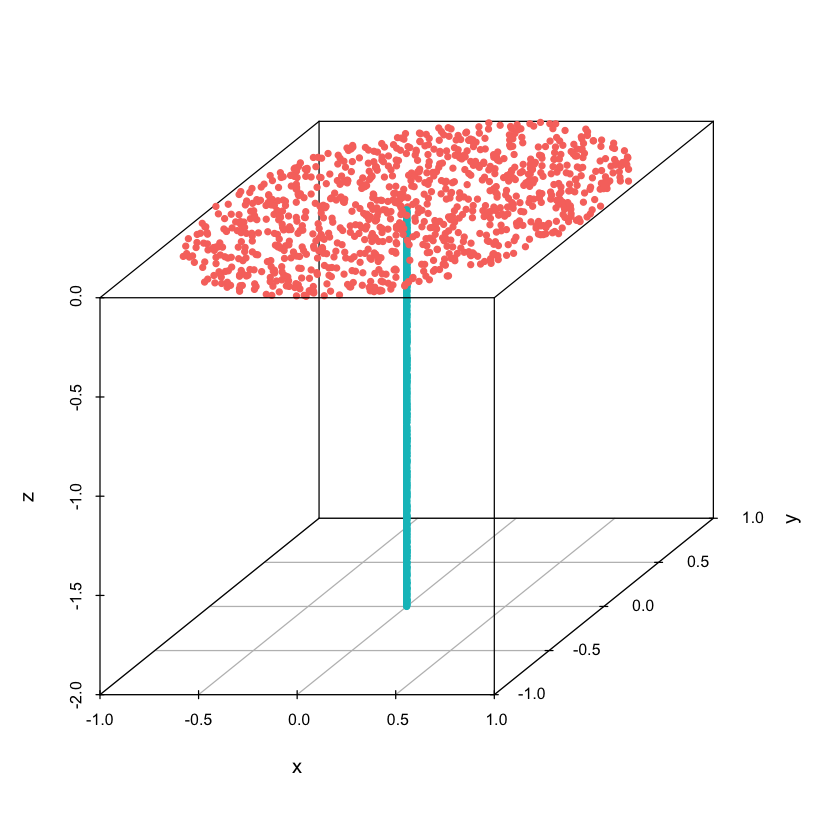

In [3]:
# Sample points from inside a unit circle
rcirc <- function(n){
  t <- 2*pi*runif(n)
  u <- runif(n) + runif(n)
  r <- ifelse(u > 1, 2-u, u)
  cbind(r*cos(t), r*sin(t))
}

# Sample points from an umbrella
make_umbrella <- function(n) {
  canopy <- rcirc(n)
  handle <- runif(n, -2, 0)
  rbind(
    data.frame(x = canopy[,1], y = canopy[,2], z = 0),
    data.frame(x = 0, y = 0, z = handle))
}

set.seed(123)
color_palette <- c("#F8766D", "#00BFC4")
umbrella <- make_umbrella(1000)
umbrella_parts <- ifelse(umbrella$z == 0, "canopy", "handle")
umbrella_colors <- ifelse(umbrella_parts == "canopy", color_palette[1], color_palette[2])

scatterplot3d(umbrella, color = umbrella_colors, pch = 20)

We have sampled $2000$ points from our probabilistic umbrella. The canopy is a unit circle with the radius of $1$, and the handle is represented by points on the $z$ axis. The length of the handle is $2$.

Let's see if we can use an algorithm to separate the umbrella into its parts

## PCA - Principal component analysis

PCA is the simplest technique for dimensionality reduction. One way to think about PCA is as a rotation and scaling of our data. 

PCA finds a new set of axes, along which the variance is maximized. It also scales the data along these axes. Let us demonstrate what happens to our umbrella.

In [4]:
pca <- prcomp(umbrella)
pca

Standard deviations:
[1] 0.6472642 0.3536357 0.3485850

Rotation:
          PC1          PC2          PC3
x 0.001388779  0.193266145  0.981145386
y 0.001677866 -0.981145401  0.193263773
z 0.999997628  0.001377829 -0.001686869

The result of the PCA is the principal component matrix and variance vector. Each of the columns of the matrix is a principal component - the axis of the object rotation.

## Principle components

Notice above that `PC1` is almost equal to $(0, 0, 1)$. This happens because the handle of the umbrella contains most variance, and becomes the fist prinicpal component. `PC2` and `PC3` are along the canopy ($z$ component is close to zero). Notice that they are orthogonal (perpendicular vectors). This orthogonality is one of the key properties of PCA - it does not reshape the original object (only rotates and scales it). In other words, the PCA presents a linear transofrmation of the data.

Let's test the orthogonality property:

In [5]:
pca$rotation[,1] %*% pca$rotation[,2]
pca$rotation[,1] %*% pca$rotation[,3]
pca$rotation[,2] %*% pca$rotation[,3]

-4.857226e-17


6.288373e-18


1.803714e-17


We can see that the product of these vectors is very close to zero. This means that they can not be projected onto each other - _i.e_ they are perpendicular.

## Standard deviations

The standard deviations vector show us how much randomness is associated with each principle component. We can also normalize this vector to check the proportion of variance for each axis.

In [6]:
pca$sdev
normalize <- function(x) x / sum(x)
normalize(pca$sdev)

[1] 0.6472642 0.3536357 0.3485850

[1] 0.4796380 0.2620524 0.2583097

Recall that the length of the handle is $2$, and the canopy has a radius of $1$. We see that half of the variance belongs the first principal component (which is just the $z$ axis), while the other half is split between `PC2` and `PC3`.

## Reduction of dimensions

The dimensionality reduction of PCA comes from only considering the first $k$ principal components. In the umbrella case, `PC1` ang `PC2` represent 75% of the variance of the object.

To rotate the object, we need to multiply the data matrix by the rotation matrix of the PCA. We can then plot the desired components. 

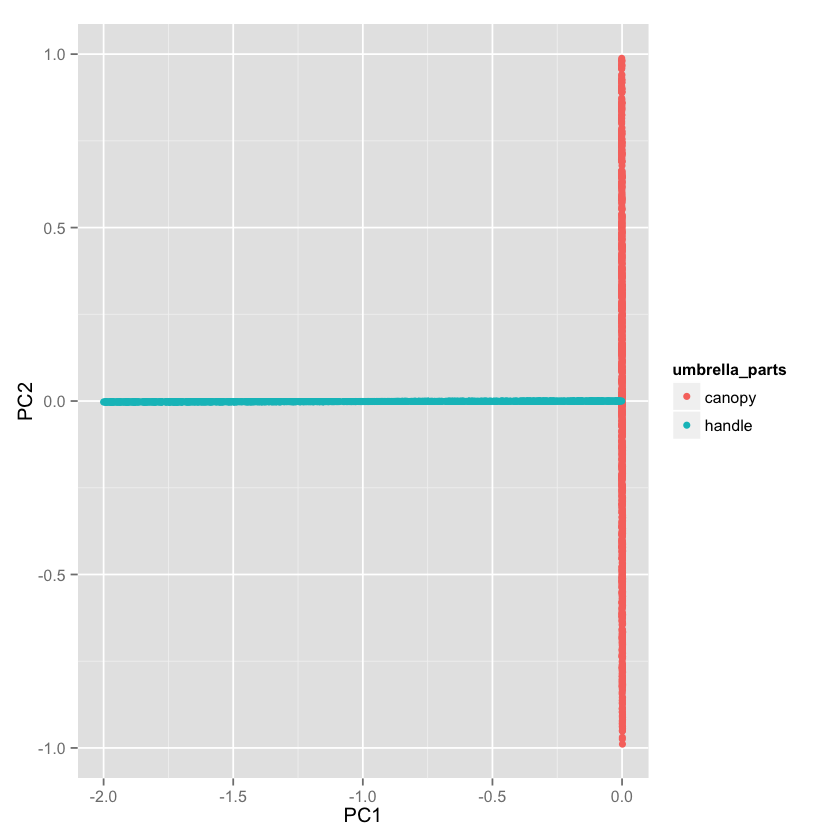

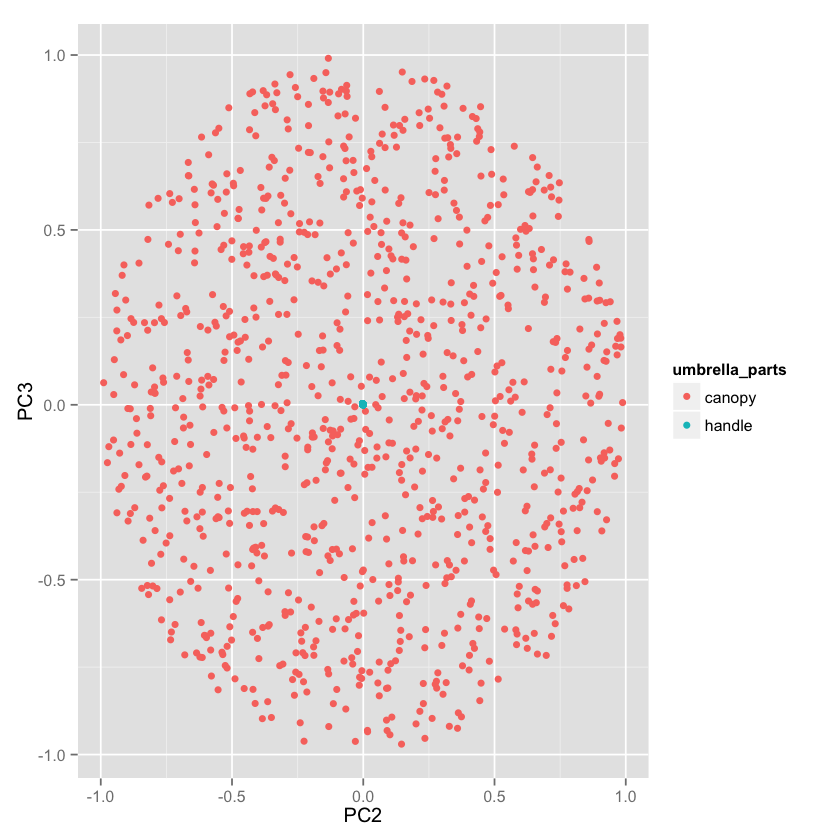

In [7]:
rotated <- as.matrix(umbrella) %*% pca$rotation
qplot(rotated[,1], rotated[,2], color = umbrella_parts, xlab = 'PC1', ylab = 'PC2')
qplot(rotated[,2], rotated[,3], color = umbrella_parts, xlab = 'PC2', ylab = 'PC3')


The PCA gives us the rotations of the object, identifying the dimension of most variance. Since the handle is perpendicular to the canopy, we can separate these parts. However, if the handle was broken, the PCA would not be able to identify it as a separate component.

## Applications

PCA gives us a linear transformation of the data. Since it does not deform our data, it is often used as a _pre-processing_ transformation. It is often used as a first-pass analysis to see what the data look like.

When PCA is used for plotting, we need to pay attention how much variance each component captures. For high-dimensional data, this proportion can often be very small.

The simplicity the main limitation of the PCA. Since all the components are orthogonal, we really only get **one** axis of maximum variation. The others are constrained to be perpendicular to it. 

Quite often, when using PCA, we will see that the variance of each principal component is very low. This means that the features of our dataset are non-perpendicular. 

## Practical example

Coming soon.

Required dataset: 
* many measurements
* Cell-type RNA-seq DE?

Point to demonstrate:

* low proportion of variance captured by PC.

## Optional - technical details

PCA is really an eigen-decomposition of the covariance matrix. If the components are independent, the covariance matrix is positive definite. This means that the eigenvalues are unique.

The properties of stretching and rotation are the consequences of using the eigenvectors of the covariance.

By default, the covariance measure used is the simple linear covariance (Pearson). However, different measures can be used if you know what you are doing.

Let us reproduce the PCA results manually:

In [8]:
manual_pca <- eigen(cov(umbrella))
manual_pca

0.001388779,0.193266145,0.981145386
0.001677866,-0.981145401,0.193263773
0.999997628,0.001377829,-0.001686869


## Additional resources

[Explained visually - PCA](http://setosa.io/ev/principal-component-analysis/)

# MDS - Multidimensional scaling

Multidimensional scaling is the next tier of dimensional reduction. The simplest case of MDS is also known as Principal Coordinate Analysis (PCoA).

The idea behind MDS is to take the distances between points in the dataset and try to represent them in smaller number of dimensions. Since it is not possible to perfectly represent an object in lower dimensions, we need a measure that allows us to tell how badly we do.

One such measure is _stress_. It expresses how much the object is deformed by projecting it:

$$Stress = \sqrt{\frac{\sum(f(x)-d)^2}{\sum d^2}}$$

Here, $d$ is some distance between points, and $f(x)$ is the transformation of our data. So this formula is the sum of the distance differences between the two spaces. 

Usually, we assume that our points have natural distances between them, so we use euclidian distance:

$$d_{ij}=\sqrt{(x_i-x_j)^2 + (y_i-y_j)^2}$$

In this case, our stress function would look like this:

$$Stress_D(x_1, x_2, ..., x_N) = \sqrt{ \sum_{i \ne j = 1,...,N}(d_{ij} - \|x_i - x_j\|)^2}$$

In the equation above $d_{ij}$ is the distance between points $x_i$ and $x_j$ (in the high-dimensional space), and $\|x_i-x_j\|$ is the low-dimensional distance. 

Our task is to find an arrangement of points in low-dimensional space that minimize the stress function. In case of euclidian distances, we can use linear algebra to find solutions efficiently. In general cases (_e.g._ categorical data), the optimization is more complicated. Usually, we can use standard optimization algorithms to solve this problem.

## Assumptions

Notice that MDS does not make many assumptions about the data. We are not looking for orthogonal components, and make no calls about the amount of associated variance.

This means that MDS usually performs better in practice for its task of visualizing data in low dimensions. The components that MDS retrieves do not have to be orthogonal.

At the same time, its results may harder to interpret. The points returned are locations that minimize the stress functions. 

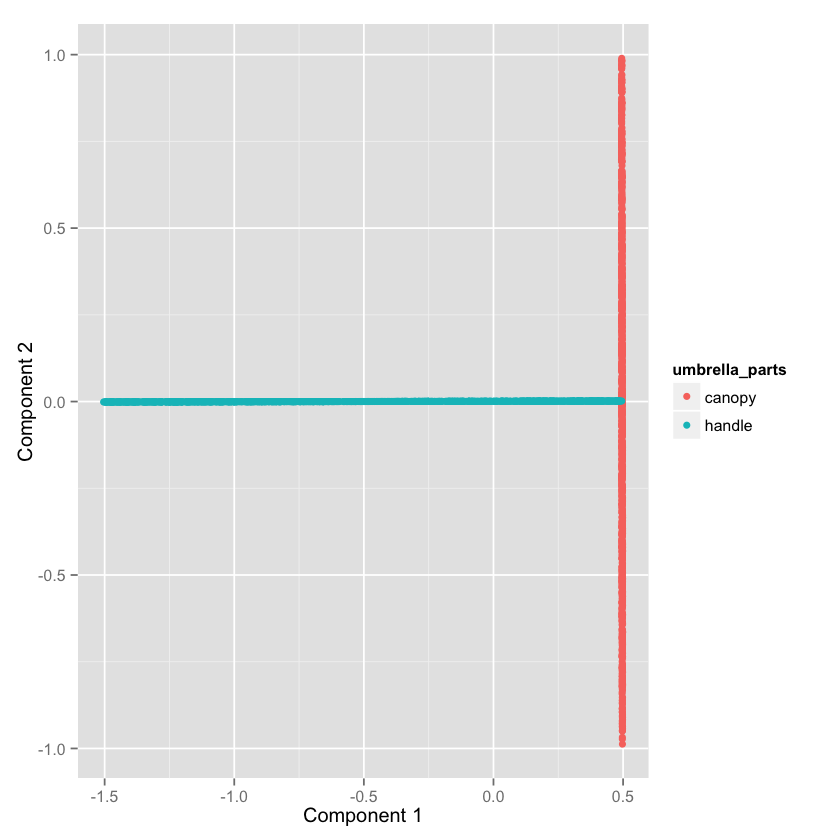

In [9]:
pcoa <- cmdscale(dist(umbrella), k = 2)
qplot(pcoa[,1], pcoa[,2], color = umbrella_parts, xlab = 'Component 1', ylab = 'Component 2')

We can also see how well the distances in the high-dimensional space have projected into low-dimensional space. Plotting the original distances versus the reconstructed distances gives us the so-called Shepard diagram:

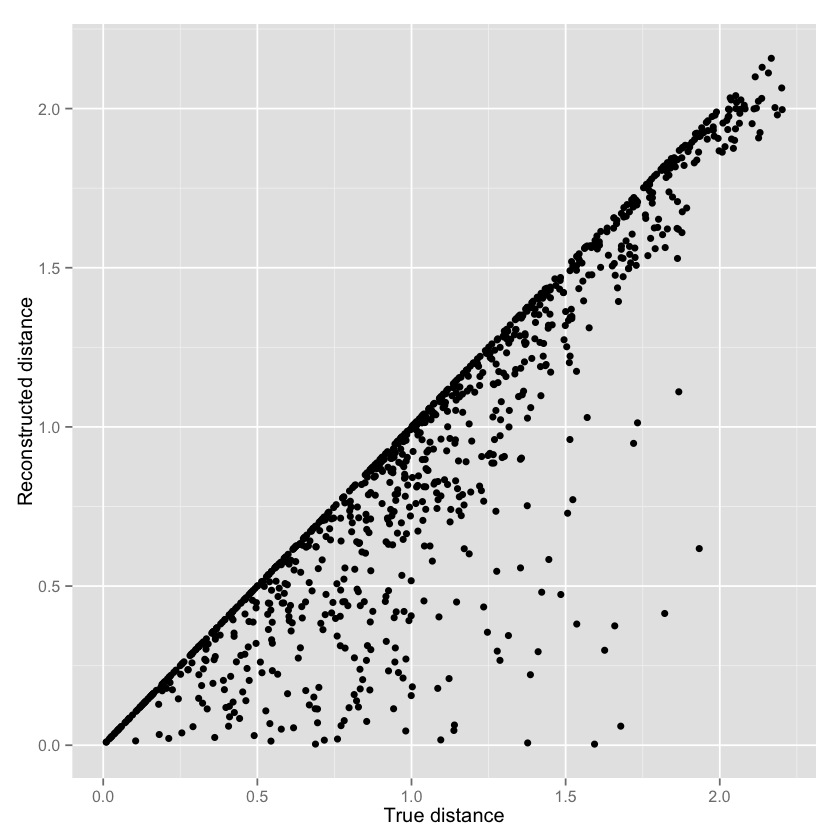

In [10]:
# Get the distances
d_hi <- dist(umbrella)
d_lo <- dist(pcoa)

# Take a subsample
subsample_index <- sample.int(length(d_lo), 1000)

qplot(x = d_hi[subsample_index], y = d_lo[subsample_index], xlab='True distance', ylab='Reconstructed distance')

If the object was projected perfectly into the 2-dimensional space, all the points will remain on $x=y$ line.

Here that the reconstructed distance is never higher than the original distance. This means that MDS does a rather good job projecting the high-dimensional object into low dimensions.

## Practical example

Coming soon.
Required dataset: same as PCA
Point to demonstrate:
* Compare preformance to PCA